In [1]:
import pandas as pd
from flask import Flask, render_template, request
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

D:\anaconda\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def clean_data(x):
    return str(x).lower().replace(" ", "")

def create_soup(x):
    return x['Movie'] + ' ' + x['director'] + ' ' + x['cast'] + ' ' + x['genre'] + ' ' + x['description']

def get_recommendations(title, cosine_sim, netflix_data):
    title = title.replace(' ', '').lower()

    if title in indices:
        idx = indices[title]
        sim_scores = list(enumerate(cosine_sim[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[1:11]
        movie_indices = [i[0] for i in sim_scores]
        result = netflix_data.iloc[movie_indices][['Movie', 'Rating']]
        result = result.reset_index(drop=True)
        return result
    else:
        result = pd.DataFrame(columns=['No movies found'])
        return result

def get_recommendations_by_genre(genre, netflix_data):
    genre = clean_data(genre)
    netflix_data['cleaned_genre'] = netflix_data['genre'].apply(clean_data)
    
    genre_indices = netflix_data[netflix_data['cleaned_genre'].str.contains(genre)].index
    
    if not genre_indices.empty:
        # Sorting by rating and selecting top 10 movies
        top_genre_recommendations = netflix_data.loc[genre_indices, ['Movie', 'Rating']].sort_values(by='Rating', ascending=False).head(10)
        top_genre_recommendations = top_genre_recommendations.reset_index(drop=True)
        return top_genre_recommendations
    else:
        result = pd.DataFrame(columns=['No movies found in this genre'])
        return result

In [3]:
netflix_data = pd.read_csv('netflix_titles.csv')
netflix_data = netflix_data.fillna('')

new_features = ['Movie', 'director', 'cast', 'genre', 'description', 'Rating']
for feature in new_features:
    netflix_data[feature] = netflix_data[feature].apply(clean_data)

netflix_data['soup'] = netflix_data.apply(create_soup, axis=1)
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(netflix_data['soup'])
cosine_sim2 = cosine_similarity(count_matrix, count_matrix)
netflix_data = netflix_data.reset_index()
indices = pd.Series(netflix_data.index, index=netflix_data['Movie'])

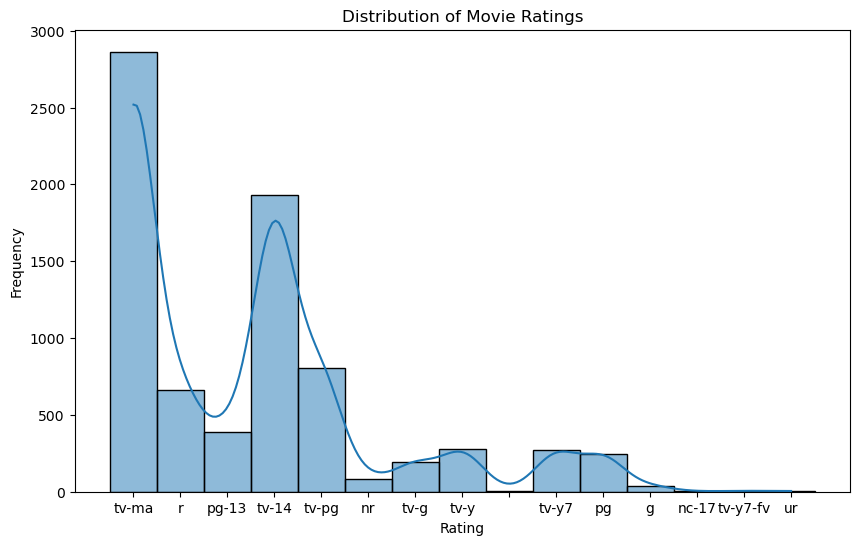

In [4]:
plt.figure(figsize=(10, 6))
sns.histplot(netflix_data['Rating'], bins=20, kde=True)
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

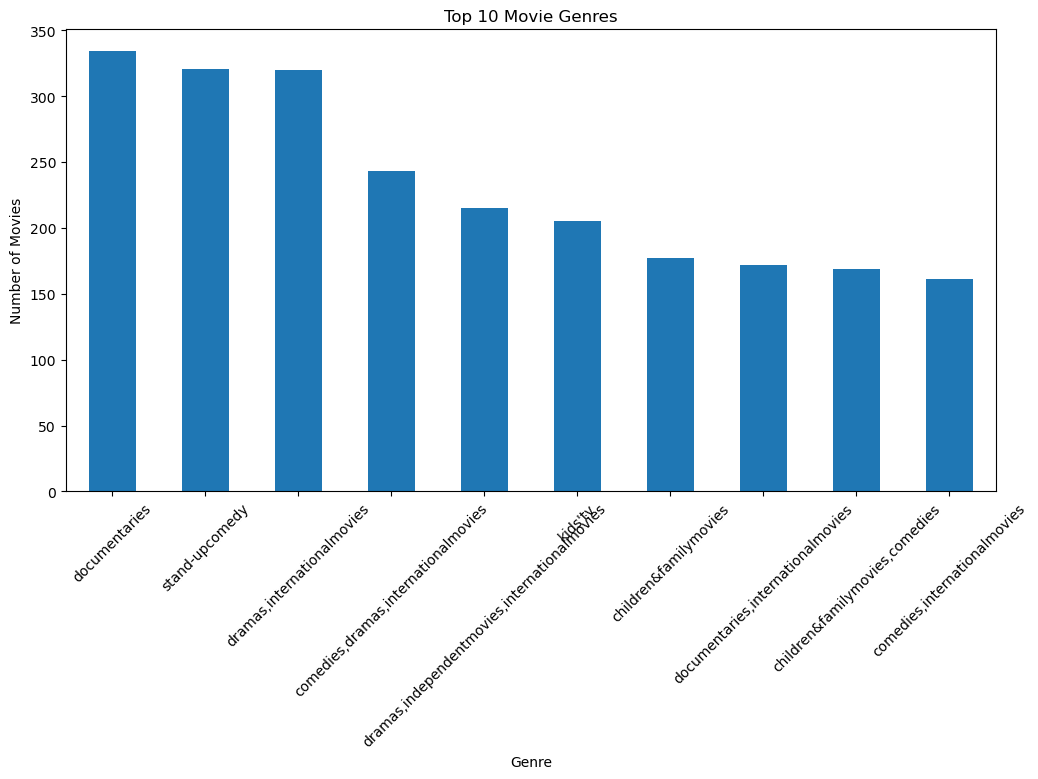

In [5]:
top_genres = netflix_data['genre'].value_counts().head(10)
plt.figure(figsize=(12, 6))
top_genres.plot(kind='bar')
plt.title('Top 10 Movie Genres')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45)
plt.show()

In [ ]:
app = Flask(__name__)

@app.route('/')
def index():
    return render_template('index.html')

@app.route('/recommend', methods=['POST'])
def recommend():
    recommend_type = request.form['recommend_type']
    input_value = request.form['input_value']

    if recommend_type == 'byname':
        recommendations = get_recommendations(input_value, cosine_sim2, netflix_data)
    elif recommend_type == 'bygenre':
        recommendations = get_recommendations_by_genre(input_value, netflix_data)
    else:
        recommendations = pd.DataFrame(columns=['Invalid recommendation type'])

    return render_template('result.html', tables=[recommendations.to_html(classes='data')], titles=recommendations.columns.values)

if __name__ == '__main__':
    app.run(debug=False)


 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [12/Mar/2024 20:12:31] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [12/Mar/2024 20:12:33] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [12/Mar/2024 20:12:39] "POST /recommend HTTP/1.1" 200 -
127.0.0.1 - - [12/Mar/2024 20:12:45] "POST /recommend HTTP/1.1" 200 -
127.0.0.1 - - [12/Mar/2024 20:13:22] "POST /recommend HTTP/1.1" 200 -
127.0.0.1 - - [12/Mar/2024 20:13:36] "POST /recommend HTTP/1.1" 200 -
127.0.0.1 - - [12/Mar/2024 20:13:40] "POST /recommend HTTP/1.1" 200 -
127.0.0.1 - - [12/Mar/2024 20:13:45] "POST /recommend HTTP/1.1" 200 -
127.0.0.1 - - [12/Mar/2024 20:13:55] "POST /recommend HTTP/1.1" 200 -
127.0.0.1 - - [12/Mar/2024 20:14:05] "POST /recommend HTTP/1.1" 200 -
